In [11]:
import pandas as pd
import subprocess
import os

from datetime import date
import json
import praw

import time
from nltk.stem import *
import re
import string 
import numpy as np

subreddit = "Cornell"
today = date.today()
today = "{}-{}-{}".format(today.month, today.day, today.year)

# We can use a script that specifys which subreddit - decided to just go with postings, because comments introduce so much extra noise that is unneeded.

In [2]:
#This scrapes the postings
def scrape_postings(subreddit):
    subprocess.run(["./post_scraper.sh", subreddit], text=True, input="Y")
    return

#This scrapes the comments
def scrape_comments(data, subreddit, min_num_comments=1):
    for i in range(len(data)):
        if data["Comment Count"][i] >= min_num_comments:
            URL = "https://reddit.com/r/{}/comments/{}".format(subreddit, data["ID"][i])
            #We have a shell script called scrape_comments which goes to each individual post
            subprocess.call(["./comment_scraper.sh", URL])
    return

In [12]:
scrape_postings(subreddit)

In [13]:
data = pd.read_json("URS-master/scrapes/{}/r-{}-Top-1000-results-past-day.json".format(today,subreddit)).transpose()
data.head()

,Title,Flair,Date Created,Upvotes,Upvote Ratio,ID,Edited?,Is Locked?,NSFW?,Is Spoiler?,Stickied?,URL,Comment Count,Text
Post 1,All of us rn,None,12-13-2020 05:07:43,215,1,kc4r24,False,False,False,False,False,https://i.redd.it/g0g6gf6l0w461.jpg,2,
Post 2,Lessons Learned from Cornell's first fully hyb...,None,12-13-2020 20:37:42,176,1,kci8ry,False,False,False,False,False,https://www.reddit.com/r/Cornell/comments/kci8...,25,What do you guys think? My two biggest complai...
Post 3,How studying has felt after Thanksgiving break,None,12-13-2020 23:25:04,189,0.99,kcldjx,False,False,False,False,False,https://i.redd.it/7cvof19dg1561.jpg,1,
Post 4,fuuuuaaaAAAAAHHHHHkkkkkk,None,12-13-2020 06:49:45,47,0.95,kc62i2,False,False,False,False,False,https://www.reddit.com/r/Cornell/comments/kc62...,2,nothing to see here. just cornell putting me i...
Post 5,tw: very long existential crisis? or idk what ...,None,12-13-2020 10:43:08,46,0.98,kc8kdt,False,False,False,False,False,https://www.reddit.com/r/Cornell/comments/kc8k...,8,ok holy shit i just randomly felt the urge to ...


# If we leave the script running on a daily basis, it will scrape that dates results for the subreddit specified.

In [14]:
#scrape_comments(data, subreddit)

#Stuffing all the comments into a pandas dataframe

"""
out = pd.DataFrame()
for file in os.listdir("URS-master/scrapes/{}".format(today)):
    if file[0] == "c":
        f = json.load(open("URS-master/scrapes/{}/{}".format(today,file)))
        f = pd.DataFrame(f).transpose()
        out = out.append(f)
        
out.columns = ["Comment_Info"]
out.head
"""

'\nout = pd.DataFrame()\nfor file in os.listdir("URS-master/scrapes/{}".format(today)):\n    if file[0] == "c":\n        f = json.load(open("URS-master/scrapes/{}/{}".format(today,file)))\n        f = pd.DataFrame(f).transpose()\n        out = out.append(f)\n        \nout.columns = ["Comment_Info"]\nout.head\n'

In [15]:
#Stuffing all the posts into a dataframe

data = pd.read_json("URS-master/scrapes/{}/r-{}-Top-1000-results-past-day.json".format(today,subreddit)).transpose()
data = data.sort_values("Comment Count")

postings = {}
for i in range(len(data)):
    post = {}
    for col in data:
        if data[col][i] == None:
            pass
        else:
            post[col] = data[col][i]
    post["Comment ID"] = data["ID"][i]
    postings[data["ID"][i]] = post

idx = postings.keys()
postings = pd.DataFrame([postings.values()]).transpose()
postings.index = idx
postings.columns = ["Comment_Info"]
postings

,Comment_Info
kcpbax,{'Title': 'Can someone drop the email of the p...
kcmmw5,{'Title': 'Subletting an apartment for $600 a ...
kcksaq,{'Title': 'what percentage is an A in math 111...
kcm2am,{'Title': 'MATH 4870 (Set Theory) Thoughts? Ho...
kcbcib,"{'Title': 'AEM 2015 Business Case for D&I', 'D..."
...,...
kcn5ve,"{'Title': 'Human bonding', 'Date Created': '12..."
kckbx5,{'Title': 'SIR WHAT THE HELL WAS THAT 2940 FIN...
kc64kb,"{'Title': 'Can Professor see your GPA?', 'Date..."
kcbu2u,{'Title': 'How do I deal with my imposter synd...


In [16]:
#Combining the two!
#We know that a row is a Posting if there is a "Title" field
#out = out.append(postings)
#data = pd.json_normalize(out['Comment_Info'])
data = pd.json_normalize(postings['Comment_Info'])

#Selecting only the relevant fields
#data = data[["Parent ID", "Comment ID", "Date Created", "Upvotes", "Text", "Title", "Upvote Ratio","Comment Count"]]
data = data[["Comment ID", "Date Created", "Upvotes", "Text", "Title", "URL", "Upvote Ratio","Comment Count"]]
data["Text"] = data["Title"] + " " + data["Text"]

data

,Comment ID,Date Created,Upvotes,Text,Title,URL,Upvote Ratio,Comment Count
0,kcpbax,12-14-2020 03:12:04,2,Can someone drop the email of the prof for INF...,Can someone drop the email of the prof for INF...,https://www.reddit.com/r/Cornell/comments/kcpb...,0.75,0
1,kcmmw5,12-14-2020 00:34:03,4,Subletting an apartment for $600 a month Febru...,Subletting an apartment for $600 a month Febru...,https://www.reddit.com/r/Cornell/comments/kcmm...,1.00,0
2,kcksaq,12-13-2020 22:53:46,3,what percentage is an A in math 1110 usually??,what percentage is an A in math 1110 usually??,https://www.reddit.com/r/Cornell/comments/kcks...,0.71,0
3,kcm2am,12-14-2020 00:01:16,6,MATH 4870 (Set Theory) Thoughts? How hard is i...,MATH 4870 (Set Theory) Thoughts? How hard is i...,https://www.reddit.com/r/Cornell/comments/kcm2...,1.00,0
4,kcbcib,12-13-2020 14:18:58,3,AEM 2015 Business Case for D&I Has anyone take...,AEM 2015 Business Case for D&I,https://www.reddit.com/r/Cornell/comments/kcbc...,1.00,0
...,...,...,...,...,...,...,...,...
82,kcn5ve,12-14-2020 01:04:19,15,Human bonding What’s human bonding like? I hea...,Human bonding,https://www.reddit.com/r/Cornell/comments/kcn5...,0.94,10
83,kckbx5,12-13-2020 22:28:24,25,SIR WHAT THE HELL WAS THAT 2940 FINAL?? DSFJAL...,SIR WHAT THE HELL WAS THAT 2940 FINAL??,https://www.reddit.com/r/Cornell/comments/kckb...,1.00,11
84,kc64kb,12-13-2020 06:54:37,7,Can Professor see your GPA? Just wondering ._.,Can Professor see your GPA?,https://www.reddit.com/r/Cornell/comments/kc64...,0.68,11
85,kcbu2u,12-13-2020 14:52:18,9,How do I deal with my imposter syndrome amidst...,How do I deal with my imposter syndrome amidst...,https://www.reddit.com/r/Cornell/comments/kcbu...,0.68,14


# Decided to just use headline titles, as comments introduced too much noise.

5741

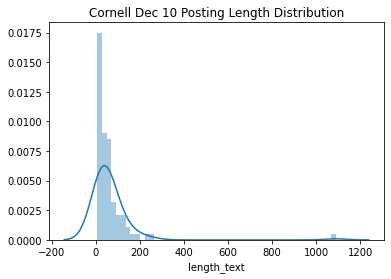

In [8]:
import seaborn as sns
data["length_text"] = data["Text"].apply(lambda x: len(x.split(" ")))
data["length_title"] = data["Title"].apply(lambda x: len(x.split(" ")))
g = sns.distplot(data["length_text"])
g.set_title("Cornell Dec 10 Posting Length Distribution")
sum(data["length_text"])

Text(0.5, 1.0, 'Cornell Dec 10 Title Length Distribution')

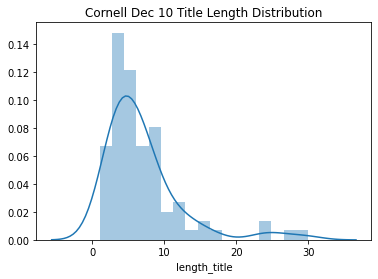

In [9]:
g = sns.distplot(data["length_title"])
g.set_title("Cornell Dec 10 Title Length Distribution")

# Preprocessing the data

In [17]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

#Stemming and removing punctuation and newlines
ps = PorterStemmer()
data["Cleaned Text"] = data["Title"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: x.replace("\n", ""))
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: [ps.stem(i.lower()) for i in str(x).split(" ")])
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: [i for i in x if i not in stopwords.words('english')])
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: " ".join(x))

#Turning time active as a feature to see freshness
data["Date Created"] = pd.to_datetime(data['Date Created'])
data["Time elapsed (mins)"] = (data['Date Created'] - min(data["Date Created"])).astype("timedelta64[m]")

#Seeing if there is an image 
data["has image"] = data["URL"].apply(lambda x: x[-4:] == ".jpg")

#Categorizing Comment Upvotes by Range of Upvotes
ratios = max(data["Upvote Ratio"])

data["Hated Comment"] = data["Upvotes"].apply(lambda x: x <=  np.percentile(ratios, 25))
data["Disliked Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 25) < x <=  np.percentile(ratios, 50))
data["Likable Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 50) < x <=  np.percentile(ratios, 75))
data["Loved Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 75) < x <=  np.percentile(ratios, 100))

#Categorizing the different types of comment ids and their parents
#comment_ID = pd.get_dummies(data["Comment ID"])
#data["Parent ID"] = data["Parent ID"].fillna("t0_None")
#parent_level = pd.get_dummies(data["Parent ID"])
#data = pd.concat([data, comment_ID,parent_level],axis=1)

keep = data[data.columns[[0,1,2,3,4,5,9]]]
vectors = data[data.columns[[6,7,8] + [i for i in range(10,len(data.columns))]]]

# Taking a look at just TFIDF Embeddings for Baseline

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(keep['Cleaned Text'])
tfidf = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

# Elbow Method to Determine Optimal Clusters -dont run this only did this for the graph.

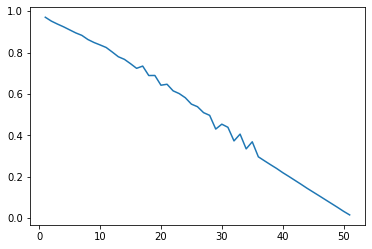

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,len(vectors)) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tfidf) 
    kmeanModel.fit(tfidf)     
      
    distortions.append(sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / tfidf.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / tfidf.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
sns.lineplot(x=range(1,len(vectors)), y=distortions)

# There does not seem to be an optimal elbow cluster, so we will do half of the number of headlines.

# Print out the headlines from the clusters

In [20]:
kmeans = KMeans(n_clusters=10).fit(tfidf)
keep["tfidf label"] = kmeans.labels_

#Looking at the most common words in each label

from collections import Counter
import nltk
from nltk.corpus import stopwords

x = keep.groupby("tfidf label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["tfidf label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)


for label in x.index:
    texts = keep[keep["tfidf label"] == label]    
    for index in texts.index:
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Are you looking for jobs in data/analytics? would you like resume review, interview tips, guidance?
	 ASIAN 1193: A Global History of Love
	 Who wants to play Dungeons and Dragons over winter break?
	 Finance clubs
	 The current state of the algo Piazza
	 A&S Pre-enroll Cap
	 MFW someone makes a joke about their grades
	 BIOG 1500 lab
	 CHEM 3590 Workload?
	 Where to Recycle Glass?
	 What’s cornell’s college of human ecology acceptance rate? RD
	 FinAid is big sad
	 Winter Break testing
	 Can I just say that
	 Do I drop premed
	 give me sth to smile for pls
	 HOW IN THE......
-----------------------------------------------
	 returning to ithaca - daily check and testing
	 Can you enroll in a course without completing the prerequisite?
	 ORIE 3510 without 3500?
	 Anybody taken ORIE 3120: Practical tools for data sci and machine learning?
-----------------------------------------------
	 Cs 1110 VS cs2110
	 INFO 2950
	 INFO 2950 vs CS 2110
	 How’s my schedule? (CS 1110 + MATH 1110 + EC

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# We see here that many of the topics with similar words are bound together, and this  alone is pretty good!

# LDA - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

data_words = keep["Cleaned Text"].apply(lambda x: x.split(" "))
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

doc_lda = lda_model[corpus]
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/usr/lib/python3/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003904 -0.068899       1        1  51.855827
1      0.003904  0.068899       2        1  48.144173, topic_info=       Term      Freq     Total Category  logprob  loglift
54     1110  2.000000  2.000000  Default  30.0000  30.0000
55       cs  2.000000  2.000000  Default  29.0000  29.0000
29   winter  1.000000  1.000000  Default  28.0000  28.0000
44    onlin  1.000000  1.000000  Default  27.0000  27.0000
24    break  1.000000  1.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
194     ivi  0.818324  1.101329   Topic2  -5.0225   0.4340
47     take  1.370126  2.210489   Topic2  -4.5071   0.2527
69           1.899390  5.008414   Topic2  -4.1805  -0.2386
60   cornel  1.345482  3.336605   Topic2  -4.5252  -0.1772
79    cours  0.821318  2.226617   Topic2  -5.0188  -0.2664

[103 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
69        1  0.598992         
69        2  0.399328         
54        1  1.069627     1110
103       2  0.907999     1340
126       1  0.595277     2930
...     ...       ...      ...
28        2  0.908003     want
139       2  0.908007    whose
29        2  0.606805   winter
82        1  0.595247  without
12        1  0.894998    would

[80 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Coherence to see optimal number of topics for LDA, seems like optimal is 1-2 topics.

In [14]:
perplexity = []
coherence = []

for k in range(1, 50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)

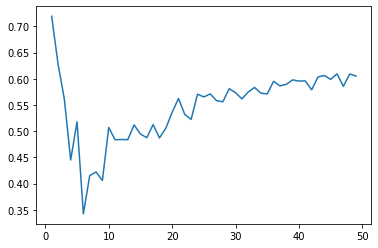

In [15]:
sns.lineplot(x=range(1,50), y=coherence)

# Start of BERT stuff - this is the best.

In [10]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('bert-large-uncased')
BERT = keep["Title"].apply(lambda x: model.encode(x))

BERT = pd.DataFrame(data=BERT.values.tolist())
BERT.head()

Exception when trying to download https://sbert.net/models/bert-large-uncased.zip. Response 404


NameError: name 'keep' is not defined

# Elbow Method to Determine Optimal Clusters

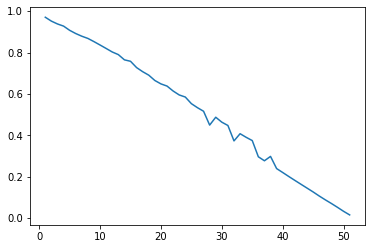

In [17]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,len(vectors)) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tfidf) 
    kmeanModel.fit(tfidf)     
      
    distortions.append(sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / tfidf.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / tfidf.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
sns.lineplot(x=range(1,len(vectors)), y=distortions)

# Function to cluster embeddings

In [22]:
kmeans = KMeans(n_clusters=10).fit(BERT)
keep["BERT label"] = kmeans.labels_

#Looking at the most common words in each label

x = keep.groupby("BERT label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["BERT label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)

count = 0
l = 0
for label in x.index:
    l += 1
    texts = keep[keep["BERT label"] == label]    
    for index in texts.index:
        count += 1
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Are you looking for jobs in data/analytics? would you like resume review, interview tips, guidance?
	 When do transfers get their financial aid for Spring 2021?
	 Who wants to play Dungeons and Dragons over winter break?
	 Board of Trustees Approve Code of Conduct Revisions
	 Anyone familiar with the 3+3 Law Program at Cornell?
	 Switching from in-person section to online
	 Can you enroll in a course without completing the prerequisite?
	 MFW someone makes a joke about their grades
	 FinAid is big sad
	 So when are we supposed to study for our finals and prelims?
	 Can I just say that
	 Alumni checking in
	 Munch munch crunch
	 finals szn😤😤😤
	 Got into Cornell for Spring 💪🏻 Need new friends in Ithaca
	 Cornell campus sure got an upgrade when this kid came here
-----------------------------------------------
	 Can’t hate Cs1110
	 ORIE 3510 without 3500?
	 MATH 1340, thoughts?? pls I am desperate
	 How’s my schedule? (CS 1110 + MATH 1110 + ECON 1110 + ? FWS)
	 Anyone take INFO/CS 3300?

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# We have reduced 160 headlines 79 headlines, a reduction of 49.375%.

# BERT + Heuristics of Upvotes, Time Active, Has an Image or not as features. The introduction of these heuristics actually introduces noise, resulting in poorer labelling. Just using BERT for the postings of the day is enough. 

In [24]:
BERT_heuristics = pd.concat([BERT, vectors],axis=1)
kmeans = KMeans(n_clusters=50).fit(BERT_heuristics)
keep["BERT + Heuristic label"] = kmeans.labels_

#Looking at the most common words in each label

x = keep.groupby("BERT + Heuristic label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["BERT + Heuristic label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)


for label in x.index:
    texts = keep[keep["BERT + Heuristic label"] == label]    
    for index in texts.index:
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 All the classes I need to take overlap but they are online and the lectures are recorded/asynchronous
	 Anybody taken ORIE 3120: Practical tools for data sci and machine learning?
-----------------------------------------------
	 HIST 2970 Thoughts
	 MATH 1340, thoughts?? pls I am desperate
-----------------------------------------------


/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Fasttext model instead - more inaccurate than BERT.

In [25]:
import fasttext
train_set = data["Title"]
train_set = train_set.reset_index(drop=True)
train_set

0                                    HIST 2970 Thoughts
1     Are you looking for jobs in data/analytics? wo...
2     When do transfers get their financial aid for ...
3                  ASIAN 1193: A Global History of Love
4     Who wants to play Dungeons and Dragons over wi...
5     Intro to the Ancient Near East (NES 2601) Info...
6                                        Summer storage
7                                         Finance clubs
8     All the classes I need to take overlap but the...
9     Board of Trustees Approve Code of Conduct Revi...
10                                    Cs 1110 VS cs2110
11    Anyone familiar with the 3+3 Law Program at Co...
12                       trying to sleep on west campus
13                                           Cornell ED
14        returning to ithaca - daily check and testing
15           Switching from in-person section to online
16    Can you enroll in a course without completing ...
17                                            IN

In [26]:
import fasttext.util

with open("train.txt", "a") as f:
    for sentence in train_set:
        f.write("{}\n".format(sentence))

model = fasttext.train_unsupervised('train.txt', model='skipgram')


fasttext.util.download_model('en', if_exists='ignore')  # English
model = fasttext.load_model('cc.en.300.bin')

#Gets average word vector of sentence
def encode_sentence(sentence):
    out = np.zeros(300)
    count = 1
    for text in sentence.split():
        out += model[text]
        count += 1
    return out / count

fasttext = pd.DataFrame(data["Title"].apply(lambda x: encode_sentence(str(x))).values.tolist())
fasttext

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.059930,-0.053979,0.001276,-0.086112,-0.022470,-0.005307,-0.033157,-0.069722,-0.020145,0.065877,...,-0.005958,-0.000974,0.153329,0.043778,0.030814,0.035518,0.087276,0.146314,-0.083581,-0.015773
1,0.020248,-0.020829,0.041659,0.058543,-0.071854,-0.016563,0.008528,-0.011193,0.040236,-0.000855,...,0.063105,0.041139,-0.054585,-0.010977,0.005420,0.027146,0.014504,0.054265,0.028823,-0.032448
2,-0.013140,0.002240,0.043854,0.057035,-0.066794,0.011274,0.017612,-0.020974,0.031475,-0.039279,...,0.050634,0.056689,-0.037643,-0.012868,-0.016953,0.025651,0.010498,0.040603,0.032885,-0.036745
3,0.053953,-0.108487,-0.009163,-0.100404,-0.009136,-0.014481,0.066794,0.033950,-0.027689,0.038807,...,-0.016444,0.017366,-0.019599,0.073810,0.017488,0.001181,-0.001965,0.084957,0.004071,0.002208
4,0.010222,-0.001811,0.019028,0.052676,-0.054579,-0.015197,0.017494,-0.011574,-0.004182,-0.004393,...,0.052420,-0.002602,-0.034169,-0.038450,0.008872,-0.002659,-0.025369,0.060246,0.005797,-0.032835
5,0.004718,0.026547,-0.034810,0.036999,-0.012500,0.001617,0.022773,0.018140,-0.025648,0.018096,...,0.071531,-0.011407,0.047485,0.022346,-0.005644,0.006032,-0.013294,0.080339,0.007204,-0.017103
6,0.025675,0.037162,-0.021995,0.008559,0.042754,0.006411,0.035511,0.018396,-0.000725,0.012521,...,-0.002984,-0.007118,0.005621,-0.014546,0.020377,0.028658,-0.000691,0.058753,-0.012232,-0.023861
7,-0.000819,0.013445,-0.021310,-0.018160,-0.055773,0.070061,-0.001844,-0.025236,0.003218,0.013710,...,-0.023976,-0.053960,-0.027944,-0.007934,0.032143,0.028595,0.005834,0.049556,-0.041961,-0.046929
8,-0.021137,0.030127,0.025787,0.056578,-0.066714,-0.021203,-0.012374,0.005075,-0.002627,-0.018764,...,0.044102,-0.014570,-0.079855,-0.030868,-0.026062,0.008736,0.026104,0.107192,-0.019877,0.001487
9,0.007117,-0.027902,-0.019117,-0.131031,-0.002462,0.013330,-0.024093,0.019199,-0.017941,-0.002718,...,-0.083376,-0.044206,0.027844,0.003830,-0.023190,-0.030817,0.037482,0.032033,-0.010277,-0.009567


In [28]:
kmeans = KMeans(n_clusters=10).fit(fasttext)
keep["fasttext label"] = kmeans.labels_

#Looking at the most common words in each label

x = keep.groupby("fasttext label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["fasttext label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)

count = 0
l = 0
for label in x.index:
    l += 1
    texts = keep[keep["fasttext label"] == label]    
    for index in texts.index:
        count += 1
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 ASIAN 1193: A Global History of Love
	 Board of Trustees Approve Code of Conduct Revisions
	 Anyone familiar with the 3+3 Law Program at Cornell?
	 Can you enroll in a course without completing the prerequisite?
	 The current state of the algo Piazza
	 MFW someone makes a joke about their grades
	 What’s cornell’s college of human ecology acceptance rate? RD
	 FinAid is big sad
	 Alumni checking in
	 Cornell campus sure got an upgrade when this kid came here
	 r/Cornell has more than double as many sub members than the other ivies (sans Harvard) based on a sub member count to total student count ratio. I included undergrad for control/curiosity. Cornell is either ahead of the intelligence curve or a producer of phenomenal procrastinators. More in comments
-----------------------------------------------
	 HIST 2970 Thoughts
	 INFO 2950
	 ORIE 3510 without 3500?
	 BIOG 1500 lab
	 CHEM 3590 Workload?
	 2930 afternoon final
	 ARKEO 2661
	 2930 morning final
------------------------------

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
